In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "유물 원한 각인서"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '유물 원한 각인서' (ID: 65200505) 데이터 수집 중...
   - 가격 로그: 7376개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:22.041111,178699
1,2025-12-18 11:10:59.700297,177998
2,2025-12-18 11:21:36.873504,178800
3,2025-12-18 11:32:12.909622,178000
4,2025-12-18 11:42:48.640077,178000


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.3
4,2026-01-14,0.0


In [3]:
import numpy as np
from datetime import timedelta

# =========================================================
# [업그레이드] 함수 1: 원본 청소 후 30분봉 만들기
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정 (필수)
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)

    # -----------------------------------------------------
    # 🚨 [핵심 추가] 원본(10분 단위) 단계에서 이상치 1차 제거
    # -----------------------------------------------------
    # 10분 데이터이므로 하루(24시간)를 보려면 window가 약 144개 필요합니다.
    # (6개/시간 * 24시간 = 144)
    raw_window = 432
    raw_sigma = 7 # 원본은 변동성이 더 크니 2.0보다 살짝 여유 있게 2.5 추천
    
    # 원본 가격 컬럼: 'current_min_price'
    rolling_mean = df['current_min_price'].rolling(window=raw_window, center=True).mean()
    rolling_std = df['current_min_price'].rolling(window=raw_window, center=True).std()
    
    upper = rolling_mean + (raw_sigma * rolling_std)
    lower = rolling_mean - (raw_sigma * rolling_std)
    
    outliers = (df['current_min_price'] > upper) | (df['current_min_price'] < lower)
    cnt = outliers.sum()
    
    if cnt > 0:
        print(f"   ✨ 원본 데이터에서 {cnt}개의 이상치를 미리 제거했습니다!")
        df.loc[outliers, 'current_min_price'] = np.nan
        df['current_min_price'] = df['current_min_price'].interpolate(method='linear')
    # -----------------------------------------------------
    
    # 2. 30분 단위 Resampling (이제 깨끗한 재료로 요리합니다)
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간 (30분봉)")
    return df_filled

# =========================================================
# [추가됨] 함수 1.5: 이상치 제거 (Rolling Z-Score)
# =========================================================
def clean_outliers_rolling(df, column='Close', window=48, sigma=3):
    print(f"🧼 [1.5단계] 이상치 제거 중... (Window={window}, Sigma={sigma})")
    df_clean = df.copy()
    
    # 이동 평균과 표준편차 계산
    rolling_mean = df_clean[column].rolling(window=window, center=True).mean()
    rolling_std = df_clean[column].rolling(window=window, center=True).std()
    
    # 이상치 판별 기준
    upper_bound = rolling_mean + (sigma * rolling_std)
    lower_bound = rolling_mean - (sigma * rolling_std)
    
    # 이상치 조건 확인 및 개수 카운트
    outlier_mask = (df_clean[column] > upper_bound) | (df_clean[column] < lower_bound)
    outlier_count = outlier_mask.sum()
    
    if outlier_count > 0:
        print(f"   🚨 {outlier_count}개의 튀는 가격 발견! 부드럽게 보정합니다.")
        # 이상치를 NaN으로 변경 후 보간(Interpolation)
        df_clean.loc[outlier_mask, column] = np.nan
        df_clean[column] = df_clean[column].interpolate(method='linear')
    else:
        print("   ✅ 데이터가 아주 깨끗합니다.")
        
    return df_clean

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 파이프라인 연결 (순서 중요!)
# =========================================================

# 1. 가격 데이터 1차 정제 (빈칸 채우기)
df_temp = preprocess_ohlc_and_fill(df_raw)

# 2. [추가] 이상치 제거 (여기서 튀는 값을 잡습니다!)
df_clean_price = clean_outliers_rolling(df_temp, column='Price_Mean', window=48, sigma=3)

# 3. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 4. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail())

🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...
   - 정제 완료: 2557개 구간 (30분봉)
🧼 [1.5단계] 이상치 제거 중... (Window=48, Sigma=3)
   🚨 3개의 튀는 가격 발견! 부드럽게 보정합니다.
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-09 17:00:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-09 15:00:00,152999.0,152999.0,152000.0,152200.0,152399.666667,0.0
2026-02-09 15:30:00,152000.0,152000.0,150888.0,151000.0,151296.000000,0.0
2026-02-09 16:00:00,151799.0,151799.0,151799.0,151799.0,151799.000000,0.0
2026-02-09 16:30:00,151998.0,152000.0,151997.0,151997.0,151998.333333,0.0
2026-02-09 17:00:00,151900.0,151900.0,151700.0,151700.0,151800.000000,0.0


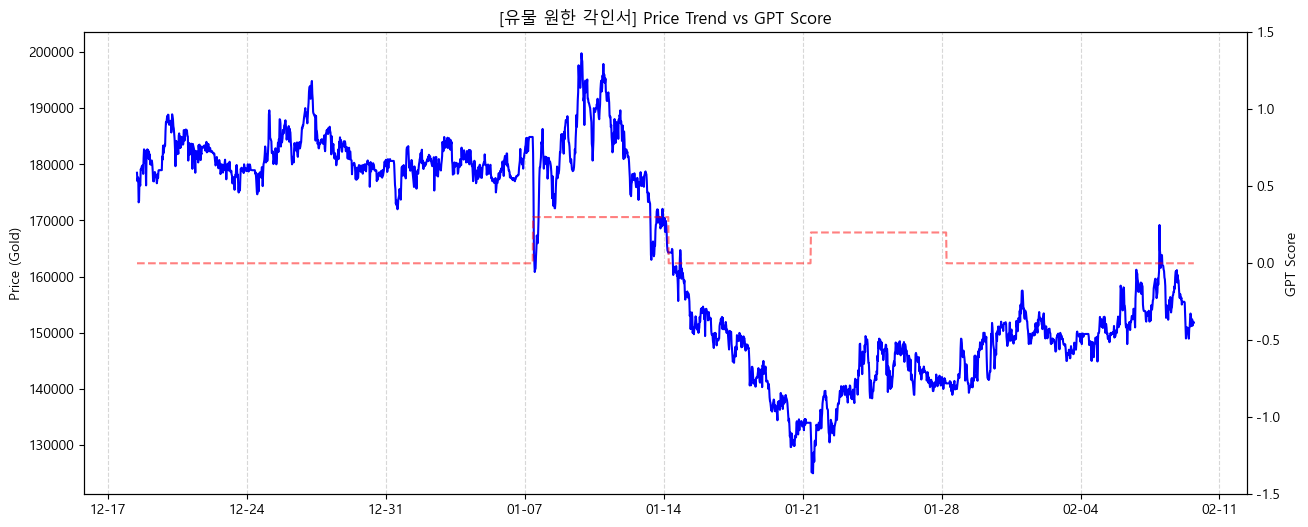

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-09 15:00:00,152999.0,152999.0,152000.0,152200.0,152399.666667,0.0
2026-02-09 15:30:00,152000.0,152000.0,150888.0,151000.0,151296.000000,0.0
2026-02-09 16:00:00,151799.0,151799.0,151799.0,151799.0,151799.000000,0.0
2026-02-09 16:30:00,151998.0,152000.0,151997.0,151997.0,151998.333333,0.0
2026-02-09 17:00:00,151900.0,151900.0,151700.0,151700.0,151800.000000,0.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [5]:
import numpy as np

# 1. 원본 복사
df_ml = df_final.copy()

# ---------------------------------------------------------
# 2. 기술적 지표 (이동평균, 변동성, RSI)
# ---------------------------------------------------------
# 가격의 흐름(Trend)을 모델에게 알려줍니다.
df_ml['MA_5'] = df_ml['Close'].rolling(window=5).mean()    # 2.5시간 평균
df_ml['MA_48'] = df_ml['Close'].rolling(window=48).mean()  # 24시간(1일) 평균
df_ml['Std_20'] = df_ml['Close'].rolling(window=20).std()  # 변동성

# RSI (상대강도지수)
delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

# ---------------------------------------------------------
# 3. [핵심] Lag Features (시차 데이터)
# ---------------------------------------------------------
# 모델 학습용으로 "과거의 정답"을 미리 만들어두는 겁니다.
# (나중에 예측할 때는 이 컬럼을 우리가 직접 채워넣으며 예측해야 합니다)
df_ml['Close_Lag1'] = df_ml['Close'].shift(1)  # 30분 전
df_ml['Close_Lag2'] = df_ml['Close'].shift(2)  # 1시간 전
df_ml['GPT_Lag1'] = df_ml['GPT_Score'].shift(1) # 30분 전 공지 점수

# ---------------------------------------------------------
# 4. 시간 정보 (Time Features)
# ---------------------------------------------------------
# 미래의 시간(요일, 시간)은 우리가 달력만 보면 100% 알 수 있으므로 아주 좋은 힌트입니다.
df_ml['Hour'] = df_ml.index.hour
df_ml['DayOfWeek'] = df_ml.index.dayofweek # 0:월 ~ 6:일

# ---------------------------------------------------------
# 5. Target (정답지: 다음 30분 뒤의 가격)
# ---------------------------------------------------------
df_ml['Target'] = df_ml['Close'].shift(-1)

# 결측치 제거 (이동평균 등으로 생긴 앞부분 빈칸 삭제)
df_ml = df_ml.dropna()

print(f"📚 머신러닝 데이터 준비 완료: {df_ml.shape}")
display(df_ml.tail())

📚 머신러닝 데이터 준비 완료: (2509, 16)


,Open,High,Low,Close,Price_Mean,GPT_Score,MA_5,MA_48,Std_20,RSI,Close_Lag1,Close_Lag2,GPT_Lag1,Hour,DayOfWeek,Target
logged_at,,,,,,,,,,,,,,,,
2026-02-09 14:30:00,151500.0,153000.0,151500.0,153000.0,152066.666667,0.0,153179.8,155229.020833,2175.020253,61.908447,151600.0,153000.0,0.0,14,0,152200.0
2026-02-09 15:00:00,152999.0,152999.0,152000.0,152200.0,152399.666667,0.0,152620.0,155201.937500,2005.721196,53.849606,153000.0,151600.0,0.0,15,0,151000.0
2026-02-09 15:30:00,152000.0,152000.0,150888.0,151000.0,151296.000000,0.0,152160.0,155077.000000,1781.134212,50.000000,152200.0,153000.0,0.0,15,0,151799.0
2026-02-09 16:00:00,151799.0,151799.0,151799.0,151799.0,151799.000000,0.0,151919.8,154989.479167,1571.091528,52.569012,151000.0,152200.0,0.0,16,0,151997.0
2026-02-09 16:30:00,151998.0,152000.0,151997.0,151997.0,151998.333333,0.0,151999.2,154876.916667,1571.014264,53.099746,151799.0,151000.0,0.0,16,0,151700.0


In [6]:
# ---------------------------------------------------------
# 1. 학습 데이터 준비 (규칙: 2월 4일 06:00 이전만 사용)
# ---------------------------------------------------------
# df_ml은 이미 정제 및 피처 엔지니어링이 끝난 데이터라고 가정합니다.
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# 학습용 데이터 (Cutoff 이전)
X_train = df_ml[df_ml.index < train_cutoff][features]
y_train = df_ml[df_ml.index < train_cutoff][target]

# 검증용 데이터 (Cutoff 이후 ~ 현재) - 과적합 방지용
X_valid = df_ml[df_ml.index >= train_cutoff][features]
y_valid = df_ml[df_ml.index >= train_cutoff][target]

print(f"📚 XGB 학습 데이터: {X_train.shape} ( ~ {train_cutoff})")
print(f"📝 XGB 검증 데이터: {X_valid.shape}")

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

# ---------------------------------------------------------
# 1. 모델 정의 (LightGBM)
# ---------------------------------------------------------
print("⚡ LightGBM 학습 시작...")

model_lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1
)

# ---------------------------------------------------------
# 2. 학습
# ---------------------------------------------------------
model_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[]
)


📚 XGB 학습 데이터: (2247, 9) ( ~ 2026-02-04 06:00:00)
📝 XGB 검증 데이터: (262, 9)
⚡ LightGBM 학습 시작...


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# ---------------------------------------------------------
# 1. 학습 데이터 준비 (규칙: 2월 4일 06:00 이전만 사용)
# ---------------------------------------------------------
# df_ml은 이미 정제 및 피처 엔지니어링이 끝난 데이터라고 가정합니다.
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# 학습용 데이터 (Cutoff 이전)
X_train = df_ml[df_ml.index < train_cutoff][features]
y_train = df_ml[df_ml.index < train_cutoff][target]

# 검증용 데이터 (Cutoff 이후 ~ 현재) - 과적합 방지용
X_valid = df_ml[df_ml.index >= train_cutoff][features]
y_valid = df_ml[df_ml.index >= train_cutoff][target]

print(f"📚 XGB 학습 데이터: {X_train.shape} ( ~ {train_cutoff})")
print(f"📝 XGB 검증 데이터: {X_valid.shape}")

# ---------------------------------------------------------
# 2. XGBoost 모델 학습
# ---------------------------------------------------------
print("\n🔥 XGBoost 학습 시작...")
model_xgb = xgb.XGBRegressor(
    n_estimators=2000,       # 학습 횟수 (넉넉하게)
    learning_rate=0.01,      # 천천히 꼼꼼하게
    max_depth=6,             # 나무 깊이
    subsample=0.8,           # 데이터 샘플링
    colsample_bytree=0.8,    # 컬럼 샘플링
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # 50번 동안 성능 향상 없으면 멈춤
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False  # 로그 너무 많이 뜨면 지저분해서 껐습니다
)
print("✅ XGBoost 학습 완료!")


📚 XGB 학습 데이터: (2247, 9) ( ~ 2026-02-04 06:00:00)
📝 XGB 검증 데이터: (262, 9)

🔥 XGBoost 학습 시작...
✅ XGBoost 학습 완료!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from neuralprophet import load
import torch
import pandas as pd
from neuralprophet import NeuralProphet, save, set_random_seed

# ---------------------------------------------------------
# 1. 설정 및 데이터 준비
# ---------------------------------------------------------
set_random_seed(42)

# PyTorch 보안 해제 (학습 시엔 필요 없지만 습관적으로 넣어두면 안전)
_original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)
torch.load = patched_torch_load

# 데이터 준비 (오전 6시 이전)
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")
df_np = df_final.reset_index()[['logged_at', 'Close', 'GPT_Score']].copy()
df_np.columns = ['ds', 'y', 'GPT_Score']
df_train = df_np[df_np['ds'] < train_cutoff]

print("✅ NeuralProphet용 데이터 준비 완료")
display(df_np.tail())

# ---------------------------------------------------------
# 2. 모델 정의
# ---------------------------------------------------------
def NeuralProphet_fit(FORECAST_HORIZON):
    m = NeuralProphet(
        n_forecasts=FORECAST_HORIZON,
        n_lags=240,
        
        n_changepoints=20,     # 좀 더 세밀하게 꺾임을 감지하도록 늘림
        trend_reg=0.05,
        weekly_seasonality=True, # 수요일 점검 등의 주간 패턴 학습
        daily_seasonality=True,  # 새벽/저녁 패턴 학습
        yearly_seasonality=False,# 1년치 데이터는 아니므로 끔
        learning_rate=0.01,
        growth='off'
    )

    # 3. GPT 점수(공지사항)를 '미래를 아는 변수'로 추가
    # (우리가 미래 공지사항은 없다고(0) 가정하고 입력할 것이기 때문)
    m.add_future_regressor("GPT_Score")

    # ---------------------------------------------------------
    # 3. 재학습 및 저장
    # ---------------------------------------------------------
    print(f"🧠 [3일 단기 속성반] 모델 학습 시작... (목표: {FORECAST_HORIZON}스텝)")

    # 학습 (보안 옵션 적용)
    m.fit(df_train, freq="30min", num_workers=0, checkpointing=False)

    # 모델 덮어쓰기
    model_filename = "lostark_price_model.np"
    save(m, model_filename)

    print(f"✅ 최적화된 모델 저장 완료: {model_filename}")
    print("   이제 이 모델은 '3일 뒤'까지만 예측하지만, 그만큼 더 정교할 겁니다!")

FORECAST_HORIZON = 144
# NeuralProphet_fit(FORECAST_HORIZON)

# ---------------------------------------------------------
# 2. 저장된 모델 불러오기 (Load)
# ---------------------------------------------------------
print("📂 [3일 예측 전용] 모델을 불러오는 중...")
# 아까 저장한 파일명 (lostark_price_model.np)
loaded_model = load("lostark_price_model.np")
print("✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)")

✅ NeuralProphet용 데이터 준비 완료


,ds,y,GPT_Score
2552,2026-02-09 15:00:00,152200.0,0.0
2553,2026-02-09 15:30:00,151000.0,0.0
2554,2026-02-09 16:00:00,151799.0,0.0
2555,2026-02-09 16:30:00,151997.0,0.0
2556,2026-02-09 17:00:00,151700.0,0.0


📂 [3일 예측 전용] 모델을 불러오는 중...


Training: |          | 0/? [00:00<?, ?it/s]

✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)


INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.963% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.data.processing._handle_missing_data) - Dropped 144 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


✅ 최종 앙상블 분석 샘플 수: 262개

🏆 AI 앙상블 최종 성적표 (검증기간: 2/4 06:00 ~ 현재)
📊 [LightGBM       ] MAE: 1481.13 | DirAcc:  46.0% | R2:  0.78
📊 [XGBoost        ] MAE: 1349.69 | DirAcc:  46.0% | R2:  0.80
📊 [NeuralProphet  ] MAE: 3226.22 | DirAcc:  45.6% | R2:  0.23
----------------------------------------------------------------------
📊 [TOTAL ENSEMBLE ] MAE: 1358.43 | DirAcc:  45.2% | R2:  0.80


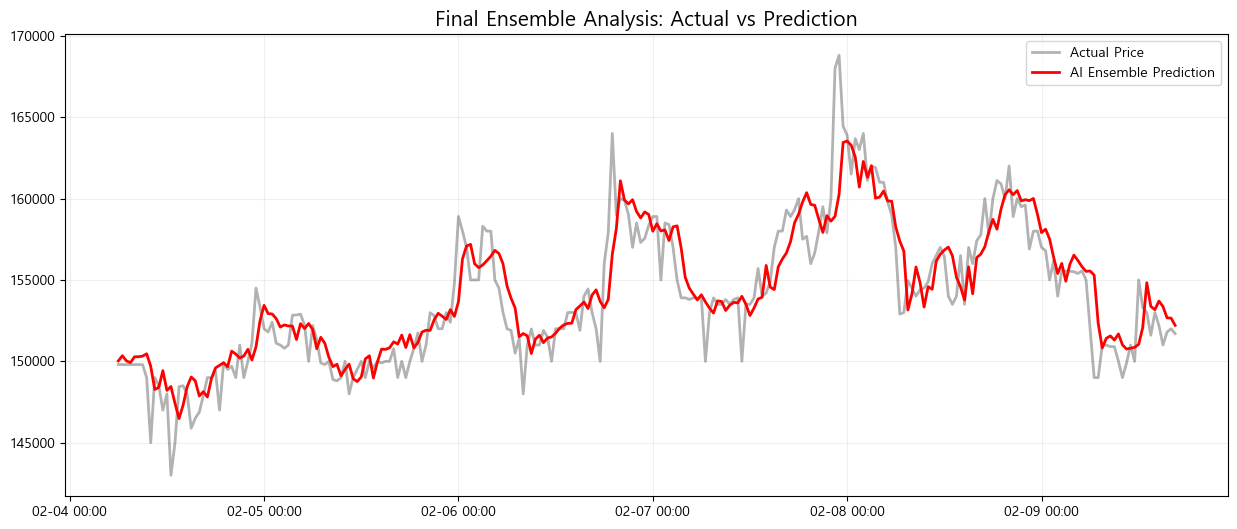

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------------------------------------
# 1. 평가 함수
# ---------------------------------------------------------
def get_ensemble_score(y_true, y_pred, name):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100
    r2 = r2_score(y_true, y_pred)
    
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    dir_acc = (np.sum(np.sign(true_diff) == np.sign(pred_diff)) / len(true_diff)) * 100
    
    print(f"📊 [{name:15}] MAE: {mae:7.2f} | DirAcc: {dir_acc:5.1f}% | R2: {r2:5.2f}")
    return mae

# ---------------------------------------------------------
# 2. 모델별 예측 데이터 생성 (시간축 동기화용)
# ---------------------------------------------------------
cutoff = pd.to_datetime("2026-02-04 06:00:00")
eval_df = df_ml[df_ml.index >= cutoff].copy()

# A. ML 모델 (LGBM, XGB)
p_lgbm_series = pd.Series(model_lgbm.predict(eval_df[features]), index=eval_df.index)
p_xgb_series = pd.Series(model_xgb.predict(eval_df[features]), index=eval_df.index)

# B. NeuralProphet (미끼 전략 적용)
last_date = df_np['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=30), periods=144, freq='30min')
df_dummy = pd.DataFrame({'ds': future_dates, 'y': np.nan, 'GPT_Score': 0.0})
df_extended = pd.concat([df_np, df_dummy], ignore_index=True)

forecast_np = loaded_model.predict(df_extended)
mask_np = (forecast_np['ds'] >= cutoff) & (forecast_np['ds'] <= last_date)
df_np_valid = forecast_np[mask_np].copy().dropna(subset=['y', 'yhat1'])

# [수정 포인트] 인덱스 이름을 df_np_valid['ds']로 정확히 매칭
p_np_series = pd.Series(df_np_valid['yhat1'].values, index=df_np_valid['ds'])

# ---------------------------------------------------------
# 3. 데이터 타임라인 통합 (Intersection)
# ---------------------------------------------------------
combined = pd.DataFrame({
    'actual': eval_df[target],
    'lgbm': p_lgbm_series,
    'xgb': p_xgb_series,
    'np': p_np_series
}).dropna()

print(f"✅ 최종 앙상블 분석 샘플 수: {len(combined)}개")

# ---------------------------------------------------------
# 4. 최종 결과 출력 (가중치 0.55 : 0.35 : 0.10)
# ---------------------------------------------------------
if not combined.empty:
    y_true = combined['actual'].values
    p_lgbm = combined['lgbm'].values
    p_xgb = combined['xgb'].values
    p_np = combined['np'].values
    
    # 앙상블 계산
    p_ensemble = (p_lgbm * 0.4) + (p_xgb * 0.4) + (p_np * 0.2)

    print("\n" + "="*70)
    print(f"🏆 AI 앙상블 최종 성적표 (검증기간: 2/4 06:00 ~ 현재)")
    print("="*70)
    get_ensemble_score(y_true, p_lgbm, "LightGBM")
    get_ensemble_score(y_true, p_xgb, "XGBoost")
    get_ensemble_score(y_true, p_np, "NeuralProphet")
    print("-" * 70)
    get_ensemble_score(y_true, p_ensemble, "TOTAL ENSEMBLE")
    print("="*70)

    # 그래프 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(combined.index, y_true, label='Actual Price', color='black', alpha=0.3, linewidth=2)
    plt.plot(combined.index, p_ensemble, label='AI Ensemble Prediction', color='red', linewidth=2)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.title("Final Ensemble Analysis: Actual vs Prediction", fontsize=15)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
else:
    print("❌ 데이터 통합 중 오류가 발생했습니다. combined 데이터프레임이 비어있습니다.")

In [10]:
# 최종 앙상블 계산
p_ensemble = (combined['lgbm'] * 0.4) + (combined['xgb'] * 0.4) + (combined['np'] * 0.2)

# 성적 계산 함수
def print_final_report(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100
    r2 = r2_score(y_true, y_pred)
    
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    dir_acc = (np.sum(np.sign(true_diff) == np.sign(pred_diff)) / len(true_diff)) * 100
    
    print("-" * 60)
    print(f"🏆 [{name} 성적표]")
    print(f"   - RMSE: {rmse:.2f}")
    print(f"   - MAE : {mae:.2f}")
    print(f"   - MAPE: {mape:.2f}%")
    print(f"   - r2  : {r2:.2f}")
    print(f"   - Dir Acc: {dir_acc:.1f}%")
    print("-" * 60)

# 출력 실행
print_final_report(combined['actual'], p_ensemble, "✨ 3대장 앙상블 (최종)")

------------------------------------------------------------
🏆 [✨ 3대장 앙상블 (최종) 성적표]
   - RMSE: 1907.97
   - MAE : 1358.43
   - MAPE: 0.88%
   - r2  : 0.80
   - Dir Acc: 45.2%
------------------------------------------------------------
